**Midterm Assignment - Mining Massive Data Sets - N03**

---





> ***Registered Group ID: 08***
*   Trần Quốc Bảo - 521H0494
*   Bùi Hải Dương - 521H0220
*   Lê Nguyễn Viết Hiệp - 521H0398
*   Bùi Anh Phú - 521H0508
*   Nguyễn Hoàng Phúc - 521H0511

[Github Repository](https://github.com/scuph-ng/mmds-midterm-2324)

Define paths to store data

In [39]:
f1 = "/content/output/f1"
f2 = "/content/output/f2"
f3 = "/content/output/f3"
f4 = "/content/output/f4"

Mount Google Drive

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


Read baskets.csv from Google Drive
- The path should be correct with your Google Drive `MyDrive/MMDS/baskets.csv` or you can change the path

In [3]:
!cp /content/drive/MyDrive/MMDS/baskets.csv /content/input

In [4]:
!ls /content/input

baskets.csv


## Installation

In [5]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!cp /content/drive/MyDrive/MMDS/spark-3.1.1-bin-hadoop3.2.tgz .
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [7]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

! echo $JAVA_HOME
! echo $SPARK_HOME

/usr/lib/jvm/java-8-openjdk-amd64
/content/spark-3.1.1-bin-hadoop3.2


## Initializing Spark

In [8]:
import findspark
findspark.init()

In [9]:
import pyspark as spark

print(spark.__version__)

3.1.1


In [10]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession

sc = SparkContext("local", "RDD")

## Read file and preprocessing file

In [11]:
csv_file_path = '/content/input/baskets.csv'

rdd = sc.textFile(csv_file_path)

Get header

In [12]:
header = rdd.first()

In [13]:
header

'Member_number,Date,itemDescription,year,month,day,day_of_week'

# Functional Requirements

## Task 1

### f1: Find the list of distinct products.

In [14]:
# Remove the header
rdd = rdd.filter(lambda line: line != header)

# Extract the product column
products = rdd.map(lambda line: line.split(',')[2])

# Get distinct products
distinct_products = products.distinct()

# Sort distinct products in the ascending order (by name)
distinct_products = distinct_products.sortBy(lambda x: x, ascending=True)

In [37]:
total_count = rdd.count()

first_10_products = distinct_products.take(10)
last_10_products = distinct_products.take(total_count)[-10:]

type(first_10_products)

list

Create an RDD from a collection of data

In [38]:
first_10_products = sc.parallelize(first_10_products)
last_10_products = sc.parallelize(last_10_products)

type(first_10_products)

pyspark.rdd.RDD

In [49]:
first_10_products.saveAsTextFile(f1 + "/first_10_products")
last_10_products.saveAsTextFile(f1 + "/last_10_products")

In [50]:
!cat /content/output/f1/first_10_products/part-00000

Instant food products
UHT-milk
abrasive cleaner
artif. sweetener
baby cosmetics
bags
baking powder
bathroom cleaner
beef
berries


In [51]:
!cat /content/output/f1/last_10_products/part-00000

turkey
vinegar
waffles
whipped/sour cream
whisky
white bread
white wine
whole milk
yogurt
zwieback


### f2: Find the list of distinct products and their frequency of being purchased

Define data visualization method

In [84]:
import matplotlib.pyplot as plt

def visualize(key, value, x_label: str, y_label: str, title: str):
  plt.figure(figsize=(30, 10))
  plt.bar(key, value, color='skyblue')

  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)

  plt.xticks(rotation=90)
  plt.tight_layout()
  plt.show()

In [61]:
# Count the frequency of each product
product_frequency = products.countByValue()

# Sort the products by frequency in descending order
sorted_products_frequency = sorted(product_frequency.items(), key=lambda x: x[1], reverse=True)

# Select top 100
top_100_products = sorted_products_frequency[:100]

In [62]:
# Extract the product names and frequencies
product_names = [product for product, _ in top_100_products]
frequencies = [count for _, count in top_100_products]

In [63]:
top_100_products = sc.parallelize(top_100_products)

In [64]:
top_100_products.saveAsTextFile(f2)

Data visualization

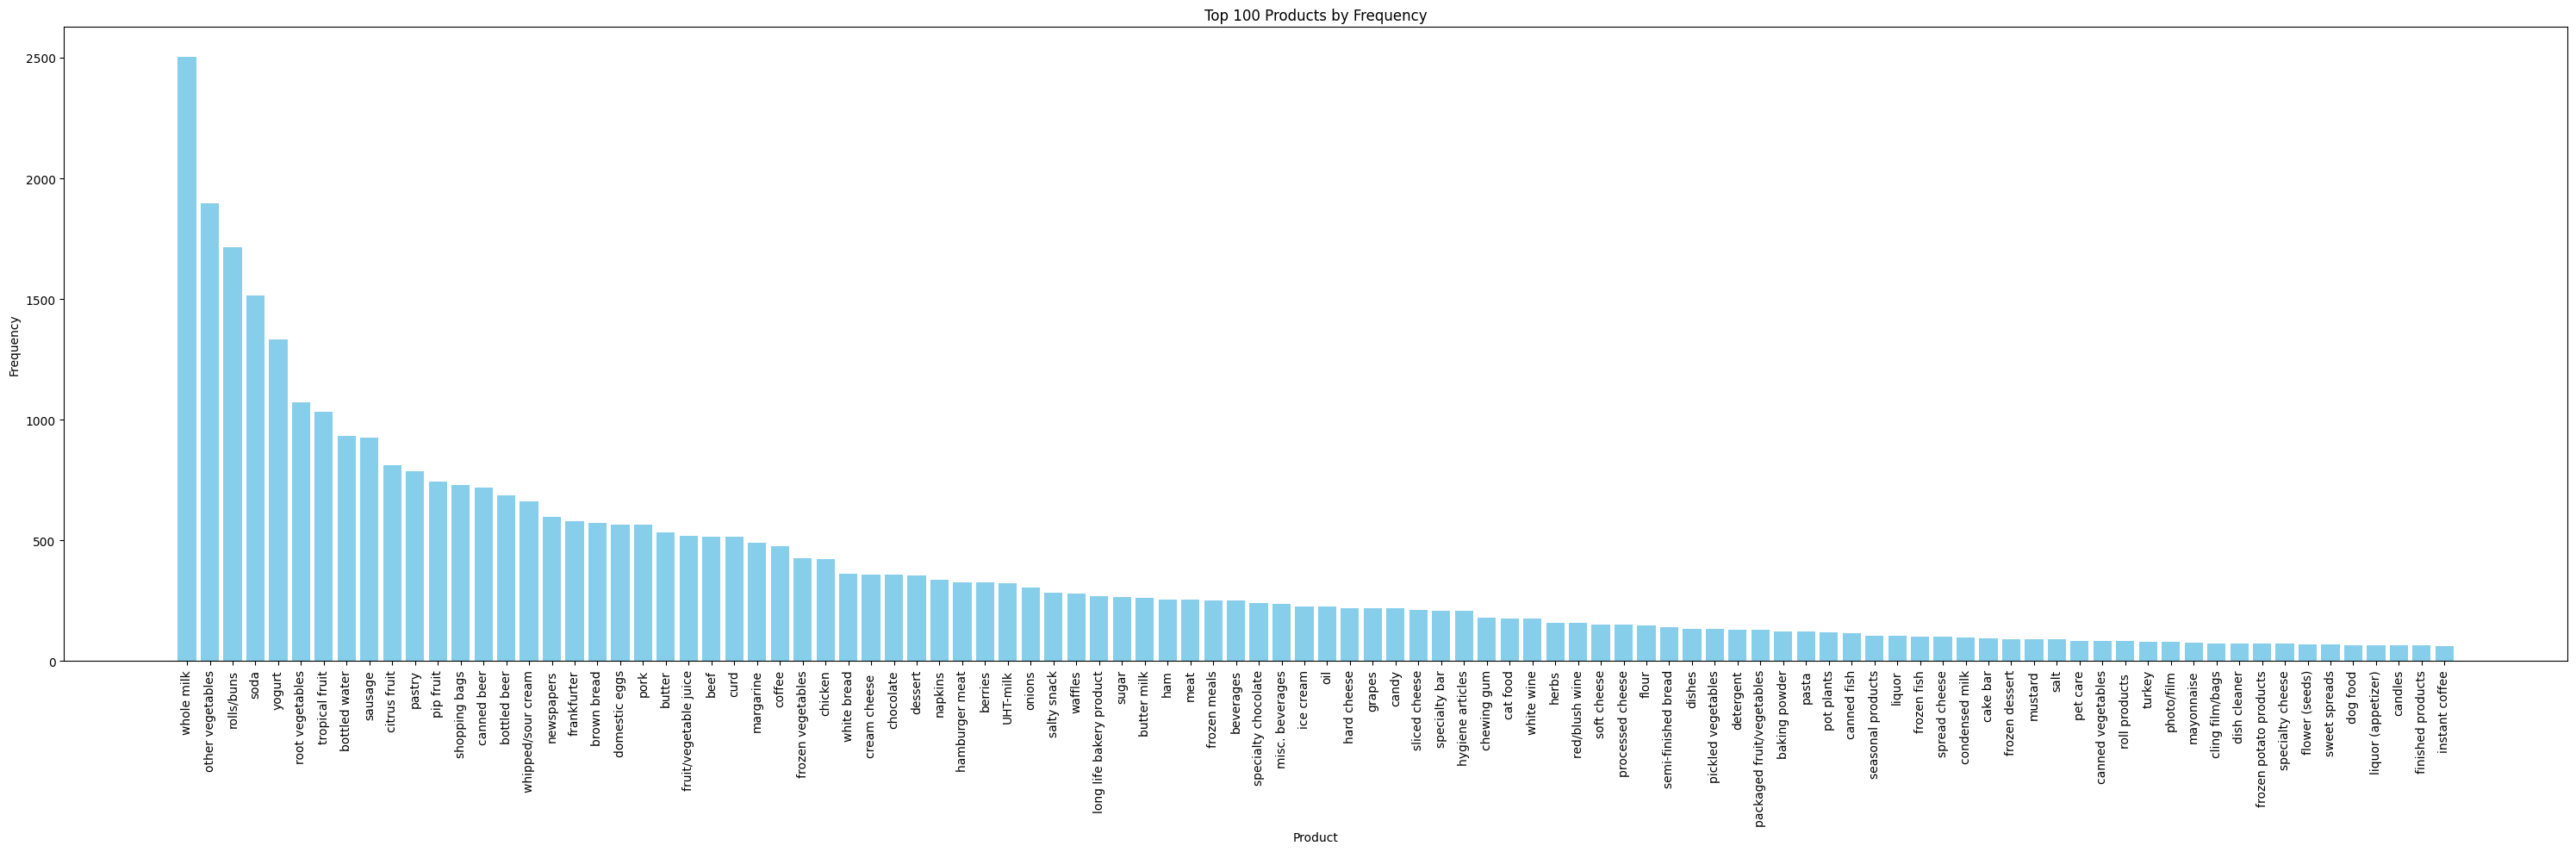

In [85]:
x_label = "Product"
y_label = "Frequency"
title = "Top 100 Products by Frequency"

visualize(key=product_names, value=frequencies, x_label=x_label, y_label=y_label, title=title)

### f3: Find the number of baskets for each member. A basket is a set of distinct products bought by a member in a date.

In [80]:
# Group the data by member and date to identify baskets
baskets = rdd.map(lambda line: ((line.split(',')[0], line.split(',')[1]), line.split(',')[2])).distinct()

# count number of distinct baskets
basket_counts = baskets.map(lambda x: (x[0][0], 1)).reduceByKey(lambda x, y: x + y)

# sort the results (descending)
sorted_basket_counts = basket_counts.sortBy(lambda x: x[1], ascending=False)

# top 100 members
top_100_members = sorted_basket_counts.take(100)

member_names = [member for member, _ in top_100_members]
basket_counts = [count for _, count in top_100_members]

In [81]:
top_100_members = sc.parallelize(top_100_members)

In [82]:
top_100_members.saveAsTextFile(f3)

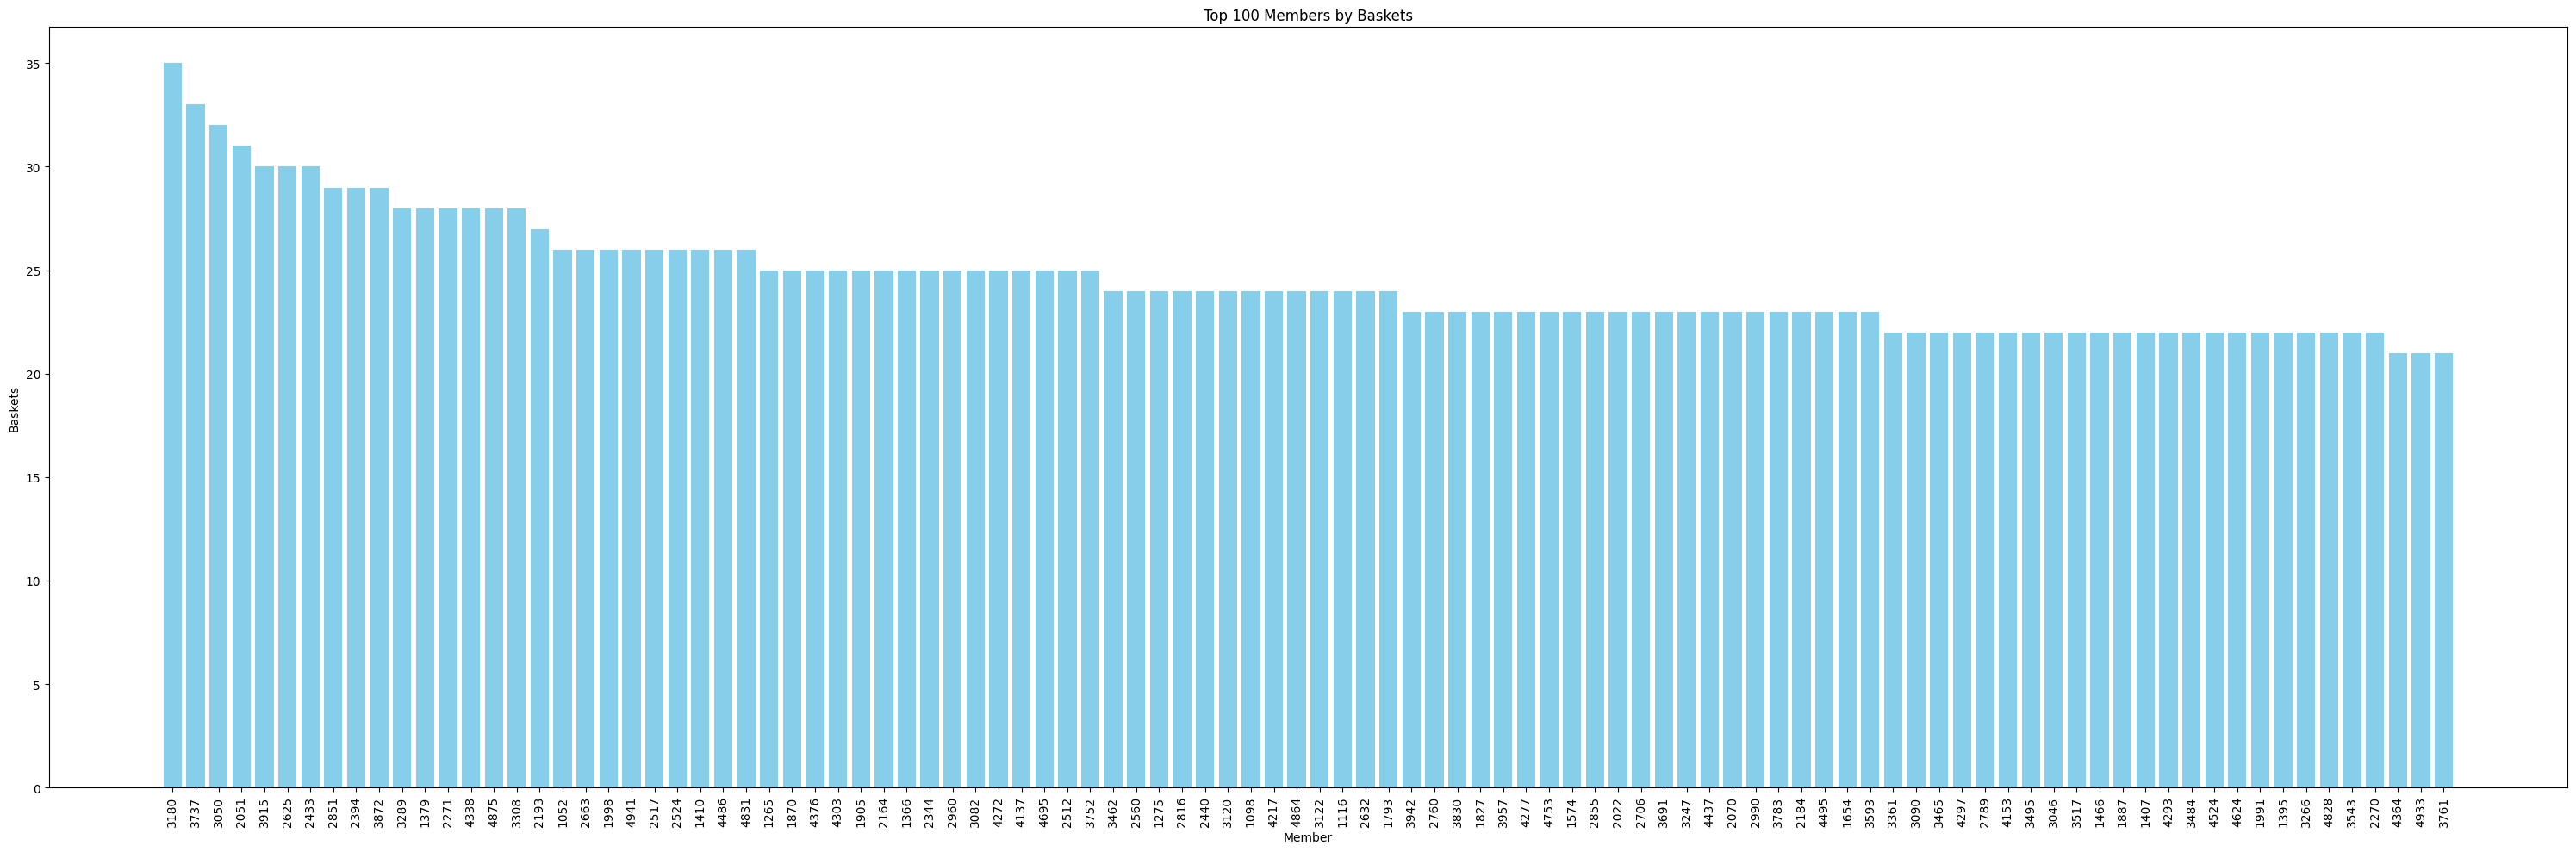

In [86]:
x_label = "Member"
y_label = "Baskets"
title = "Top 100 Members by Baskets"

visualize(key=member_names, value=basket_counts, x_label=x_label, y_label=y_label, title=title)

### f4: Find the member that bought the largest number of distinct products && Find the product that is bought by the most members.

In [97]:
# Count the number of distinct products bought by each member
member_product_counts = baskets.map(lambda x: (x[0][0], x[1])).distinct().map(lambda x: (x[0], 1)).reduceByKey(lambda x, y: x + y)
max_products_by_a_member = member_product_counts.max(lambda x: x[1])

print("Member who buy the largest number of distunct products:")
print(f"Member Number: {max_products_by_a_member[0]}, Number of Products: {max_products_by_a_member[1]}")

# Count the number of members who bought each product
product_member_counts = baskets.map(lambda x: (x[1], x[0][0])).distinct().map(lambda x: (x[0], 1)).reduceByKey(lambda x, y: x + y)
max_products_by_most_members = product_member_counts.max(lambda x: x[1])

print("\nProduct that is bought by the most members:")
print(f"Product Name: {max_products_by_most_members[0]}, Number of Members: {max_products_by_most_members[1]}")

Member who buy the largest number of distunct products:
Member Number: 2051, Number of Products: 26

Product that is bought by the most members:
Product Name: whole milk, Number of Members: 1786


In [98]:
max_products_by_a_member = sc.parallelize(max_products_by_a_member)
max_products_by_most_members = sc.parallelize(max_products_by_most_members)

In [104]:
max_products_by_a_member.saveAsTextFile(f4 + "/max_products_by_a_member")
max_products_by_most_members.saveAsTextFile(f4 + "/max_products_by_most_members")

In [105]:
!cat /content/output/f4/max_products_by_a_member/part-00000

2051
26


In [106]:
!cat /content/output/f4/max_products_by_most_members/part-00000

whole milk
1786
